In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import shapely.geometry as sg
import seaborn as sns
import ast
import folium
import os
from tqdm import tqdm

In [2]:
df_cpt = pd.read_csv('../Data/CPT.csv', index_col=0)

In [3]:
df_tcmt = pd.read_csv('../Data/Tacheometry.csv', index_col=0)

In [4]:
df_tcmt['points'] = gpd.points_from_xy(df_tcmt['X_coordinate'], df_tcmt['Y_coordinate'])
df_objects = df_tcmt.groupby('objectid').agg(
            geometry = pd.NamedAgg(column='points', aggfunc= lambda x: sg.LineString(x.values)))
df_objects = df_objects.reset_index()
gdf_objects = gpd.GeoDataFrame(df_objects, crs="EPSG:28992", geometry=df_objects['geometry'])

gdf_buffer = gdf_objects.copy()
gdf_buffer['geometry'] = gdf_buffer['geometry'].buffer(2)
gdf_buffer.crs = "EPSG:28992"
gdf_buffer = gdf_buffer.to_crs("EPSG: 4326")

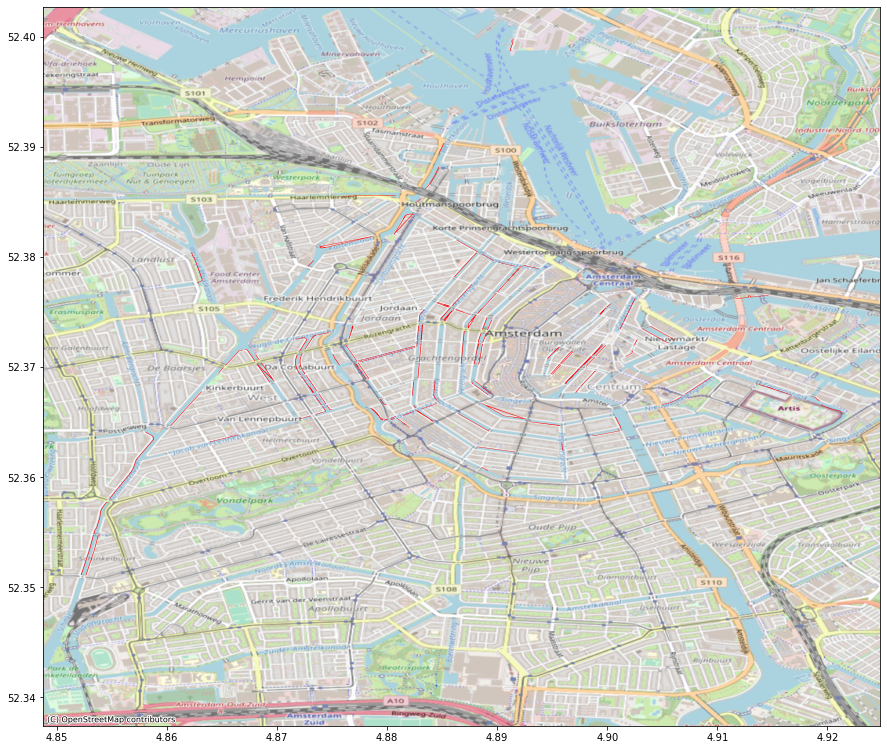

In [5]:
fig, ax = plt.subplots(figsize=(15,15))

# plot datapoints
gdf_buffer.plot(ax=ax, color='r')

# add background of city of Amsterdam
cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik, crs=gdf_buffer.crs)

# ax.axis('off')
plt.show()

In [6]:
# create geo dataframe based on X and Y coordinates
gdf_cpt = gpd.GeoDataFrame(df_cpt, geometry=gpd.points_from_xy(df_cpt['easting'], \
                                                               df_cpt['northing']))

# add the correct coordinate system (Dutch RD)
gdf_cpt.crs = "EPSG:28992"

# project onto gps coordinate system for visualisation purposes
gdf_cpt = gdf_cpt.to_crs("EPSG: 4326")

In [7]:
gdf_joined = gpd.sjoin(left_df=gdf_buffer, right_df=gdf_cpt, how='inner')

In [8]:
used_racks = ['BDG0101', 'BDG0202', 'DCG0101', 'DCG0202', 'DCG0302', 'GRW0101', 'HEG0302', 'HEG0401', 'HEG0802', 'HEG0901', 'KVV0602', 'KVV0702', 'KZG0301', 'KZG0302', 'LLG0102', 'LLG0202', 'LYG0501', 'LYG0601', 'NHG0201', 'OVW0601', 'PRG0301', 'PRG0401', 'PRG0402', 'SIN0501', 'SIN0502', 'SIN0601', 'SIN0602', 'SIN0701', 'WEG0201', 'WKN0101']

In [10]:
gdf_joined = gdf_joined[gdf_joined['objectid'].isin(used_racks)]

In [11]:
gdf_joined['objectid'].unique(), len(gdf_joined['objectid'].unique())

(array(['BDG0101', 'BDG0202', 'DCG0101', 'DCG0202', 'DCG0302', 'GRW0101',
        'HEG0302', 'HEG0401', 'HEG0802', 'HEG0901', 'KVV0602', 'KVV0702',
        'KZG0301', 'KZG0302', 'LLG0102', 'LLG0202', 'LYG0501', 'LYG0601',
        'NHG0201', 'OVW0601', 'PRG0301', 'PRG0401', 'PRG0402', 'SIN0501',
        'SIN0502', 'SIN0601', 'SIN0602', 'SIN0701', 'WEG0201', 'WKN0101'],
       dtype=object),
 30)

In [12]:
# take only depths between 7 and 11
gdf_joined = gdf_joined[(gdf_joined['depth'] >= 7) & (gdf_joined['depth'] <= 11)]

In [13]:
# create depth intervals of every 0.5 meter
cut = pd.cut(gdf_joined['depth'], bins=[(i*0.5) + 7.25 for i in range(0, 9)])

# calculate mean of frictionRatio per depth interval per object
mean = gdf_joined.groupby(['objectid', cut])['frictionRatio'].median()
df_per_depth = pd.DataFrame(mean).reset_index(level=1)
df_per_depth.index.name= None

# create columns of values per depth interval for frictionRatio
df_per_depth = df_per_depth.pivot_table(values='frictionRatio', index=df_per_depth.index, columns='depth', dropna=False)
df_per_depth = df_per_depth.dropna(axis=1, how='all')
df_per_depth.columns = [f'FrictionRatioAt{round((i*0.5 + 7.25), 2)}' for i in range(len(cut.unique())-1)]

# calculate mean of coneResistance per depth interval per object
mean = gdf_joined.groupby(['objectid', cut])['coneResistance'].median()
df_per_depth2 = pd.DataFrame(mean).reset_index(level=1)
df_per_depth2.index.name= None

# create columns of values per depth interval for coneResistance
df_per_depth2 = df_per_depth2.pivot_table(values='coneResistance', index=df_per_depth2.index, columns='depth', dropna=False)
df_per_depth2 = df_per_depth2.dropna(axis=1, how='all')
df_per_depth2.columns = [f'coneResistanceAt{round((i*0.5 + 7.25), 2)}' for i in range(len(cut.unique())-1)]

# get maximum value per objectid of elapsed time (seems cumulative, so is now total)
df_time = gdf_joined.groupby('objectid')['elapsedTime'].max()

# combine into one dataframe
gdf_joined = gdf_joined.merge(df_per_depth, left_on='objectid', right_on=df_per_depth.index)
gdf_joined = gdf_joined.merge(df_per_depth2, left_on='objectid', right_on=df_per_depth2.index)
gdf_joined = gdf_joined.merge(df_time, left_on='objectid', right_on=df_time.index)

# remove redundant columns, remove duplicate rows, to yield one row per object
gdf_joined = gdf_joined.drop(['index_right', 'coneResistance', 'localFriction', 'depth', 'elapsedTime_x', 'penetrationLength', 'frictionRatio', 'inclinationResultant', 'inclinationEW', 'inclinationNS', 'easting', 'northing', 'groundlevel'], axis=1).drop_duplicates()
gdf_joined['elapsedTime_y'] = gdf_joined['elapsedTime_y'].fillna(value=gdf_joined['elapsedTime_y'].median())

In [14]:
# delete rows with only NaN values
all_nan = gdf_joined.iloc[:,2:-1].isna().all(axis=1)
gdf_joined = gdf_joined.drop(all_nan[all_nan == True].index)

In [15]:
gdf_joined['objectid'].unique(), len(gdf_joined['objectid'].unique())

(array(['BDG0101', 'BDG0202', 'DCG0101', 'DCG0202', 'DCG0302', 'GRW0101',
        'HEG0302', 'HEG0401', 'HEG0802', 'HEG0901', 'KVV0602', 'KVV0702',
        'KZG0301', 'KZG0302', 'LLG0102', 'LLG0202', 'LYG0501', 'LYG0601',
        'NHG0201', 'OVW0601', 'PRG0301', 'PRG0401', 'PRG0402', 'SIN0501',
        'SIN0502', 'SIN0601', 'SIN0602', 'SIN0701', 'WEG0201', 'WKN0101'],
       dtype=object),
 30)

In [16]:
gdf_joined.isna().any()

objectid                 False
geometry                 False
FrictionRatioAt7.25      False
FrictionRatioAt7.75      False
FrictionRatioAt8.25      False
FrictionRatioAt8.75      False
FrictionRatioAt9.25      False
FrictionRatioAt9.75      False
FrictionRatioAt10.25     False
FrictionRatioAt10.75     False
coneResistanceAt7.25     False
coneResistanceAt7.75     False
coneResistanceAt8.25     False
coneResistanceAt8.75     False
coneResistanceAt9.25     False
coneResistanceAt9.75     False
coneResistanceAt10.25    False
coneResistanceAt10.75    False
elapsedTime_y            False
dtype: bool

In [17]:
gdf_joined.index = gdf_joined.objectid
gdf_joined.index.name = None
gdf_joined = gdf_joined.drop(['objectid', 'geometry'], axis=1)

In [31]:
gdf_joined.to_csv('../Data/CPT_train_v2.csv', index = True)